
=== Compile Success by ModelType ===
{
  "MILP": "100.0%",
  "LP": "100.0%",
  "CP": "100.0%",
  "CP-SAT": "100.0%",
  "other": "100.0%",
  "MINLP": "100.0%",
  "CP (Sum-only linear constraints over integer and binary domains)": "100.0%",
  "NLP": "100.0%"
}


/var/folders/mz/bxcym_6d5p3_tlvk9sq3x5z40000gn/T/ipykernel_67452/4013496463.py:75: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("RdYlGn")  # red → yellow → green


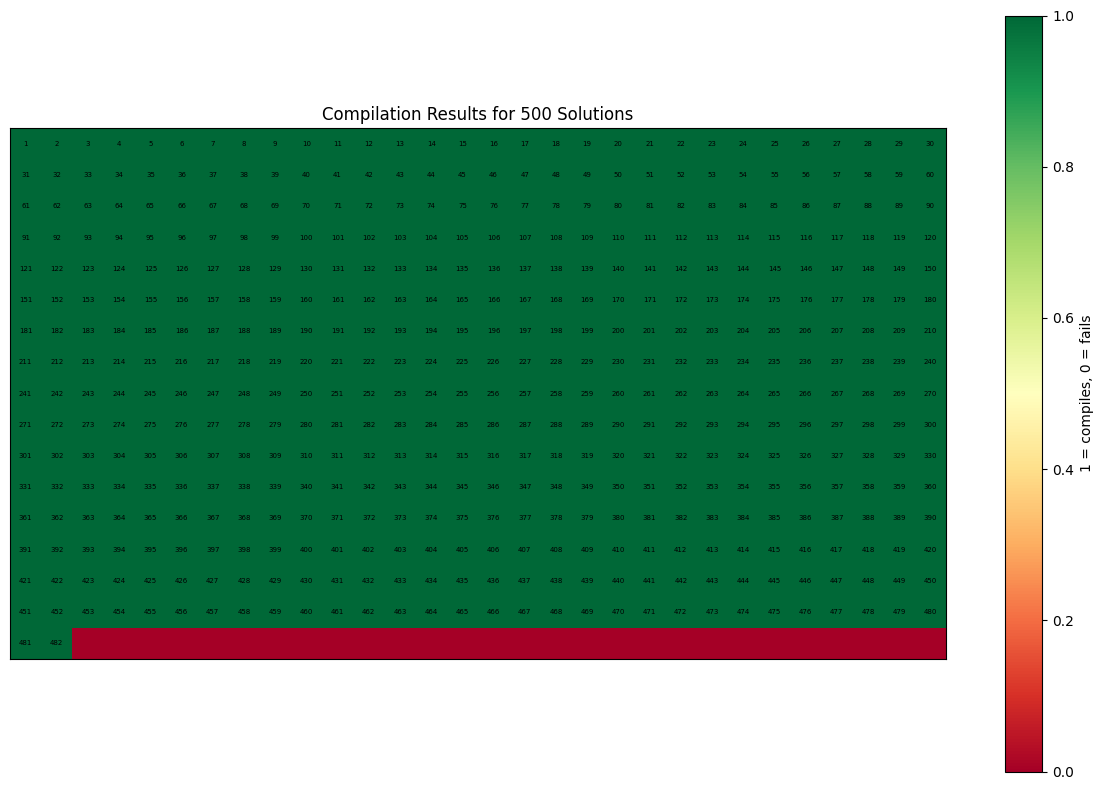

In [15]:
import os
import json
import py_compile
import matplotlib.pyplot as plt
import numpy as np

PROBLEMS_DIR = "generated_updated_problems"
SOLUTIONS_DIR = "generated_updated_solutions"

def try_compile(path):
    """Return True if Python file compiles, False otherwise."""
    try:
        py_compile.compile(path, doraise=True)
        return True
    except Exception:
        return False

def extract_model_type(problem_id):
    """Return ModelType from generated_updated_problems/problem_{id}.json."""
    json_path = os.path.join(PROBLEMS_DIR, f"problem_{problem_id}.json")
    if not os.path.exists(json_path):
        return None
    try:
        with open(json_path, "r", encoding="utf-8") as f:
            data = json.load(f)
        return data["Problem"]["ModelType"]
    except Exception:
        return None

def main():
    results = []             # True/False for each solution
    model_types = []         # ModelType for each solution
    modeltype_success = {}   # {ModelType: {"ok": x, "total": y}}

    for i in range(1, 483):
        sol_path = os.path.join(SOLUTIONS_DIR, f"solution_{i}.py")
        
        # Check compile success
        compiles = try_compile(sol_path)
        results.append(compiles)

        # Get corresponding ModelType
        model_type = extract_model_type(i)
        model_types.append(model_type)

        # Track stats
        if model_type not in modeltype_success:
            modeltype_success[model_type] = {"ok": 0, "total": 0}
        modeltype_success[model_type]["total"] += 1
        if compiles:
            modeltype_success[model_type]["ok"] += 1

    # Compute percentages
    summary = {}
    for mt, stats in modeltype_success.items():
        if stats["total"] > 0:
            pct = 100 * stats["ok"] / stats["total"]
        else:
            pct = 0.0
        summary[mt] = f"{pct:.1f}%"

    print("\n=== Compile Success by ModelType ===")
    print(json.dumps(summary, indent=2))

    # ---- GRID PLOT (20 × 30) ----
    grid = np.zeros((17, 30))  # 17 rows, 30 columns = 510 possible
    for idx, ok in enumerate(results):
        r = idx // 30
        c = idx % 30
        grid[r, c] = 1 if ok else 0   # green=1, red=0

    plt.figure(figsize=(12, 8))
    plt.title("Compilation Results for 500 Solutions")

    cmap = plt.cm.get_cmap("RdYlGn")  # red → yellow → green
    plt.imshow(grid, cmap=cmap, vmin=0, vmax=1)

    plt.colorbar(label="1 = compiles, 0 = fails")
    plt.xticks([])
    plt.yticks([])

    # Label each square with the solution number
    for idx in range(482):
        r = idx // 30
        c = idx % 30
        plt.text(c, r, str(idx + 1), ha="center", va="center", fontsize=5, color="black")

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()


In [12]:
import os
import json
import py_compile
import shutil

PROBLEMS_DIR = "generated_updated_problems"
SOLUTIONS_DIR = "generated_updated_solutions"

def try_compile(path):
    """Return True if Python file compiles, False otherwise."""
    try:
        py_compile.compile(path, doraise=True)
        return True
    except Exception:
        return False


def load_model_type(problem_id):
    """Return ModelType from json file, or None on error."""
    path = os.path.join(PROBLEMS_DIR, f"problem_{problem_id}.json")
    if not os.path.exists(path):
        return None
    try:
        with open(path, "r", encoding="utf-8") as f:
            return json.load(f)["Problem"]["ModelType"]
    except:
        return None


def main():

    # -----------------------------
    # STEP 1 — Determine which files compile
    # -----------------------------
    compile_results = {}   # {index: True/False}
    max_files = 500

    for i in range(1, max_files + 1):
        sol_path = os.path.join(SOLUTIONS_DIR, f"solution_{i}.py")
        if not os.path.exists(sol_path):
            continue
        compiles = try_compile(sol_path)
        compile_results[i] = compiles

    # -----------------------------
    # STEP 2 — Delete failures
    # -----------------------------
    deleted = 0

    for i, ok in compile_results.items():
        if ok:
            continue

        # delete solution
        sol_path = os.path.join(SOLUTIONS_DIR, f"solution_{i}.py")
        if os.path.exists(sol_path):
            os.remove(sol_path)

        # delete problem
        prob_path = os.path.join(PROBLEMS_DIR, f"problem_{i}.json")
        if os.path.exists(prob_path):
            os.remove(prob_path)

        deleted += 1

    print(f"Deleted {deleted} solution/problem pairs due to compilation failure.")

    # -----------------------------
    # STEP 3 — Renumber remaining files sequentially
    # -----------------------------
    print("Renumbering remaining files...")

    # Gather remaining valid indices
    remaining = []
    for i in range(1, max_files + 1):
        sol_path = os.path.join(SOLUTIONS_DIR, f"solution_{i}.py")
        prob_path = os.path.join(PROBLEMS_DIR, f"problem_{i}.json")
        if os.path.exists(sol_path) and os.path.exists(prob_path):
            remaining.append(i)

    # Create mapping old → new
    mapping = {old: new for new, old in enumerate(remaining, start=1)}

    # Temporary directories to avoid overwriting
    TMP_PROB = os.path.join(PROBLEMS_DIR, "_tmp")
    TMP_SOL = os.path.join(SOLUTIONS_DIR, "_tmp")

    os.makedirs(TMP_PROB, exist_ok=True)
    os.makedirs(TMP_SOL, exist_ok=True)

    # Move to temporary folder with new names
    for old, new in mapping.items():
        shutil.move(
            os.path.join(PROBLEMS_DIR, f"problem_{old}.json"),
            os.path.join(TMP_PROB, f"problem_{new}.json")
        )
        shutil.move(
            os.path.join(SOLUTIONS_DIR, f"solution_{old}.py"),
            os.path.join(TMP_SOL, f"solution_{new}.py")
        )

    # Clean old directories
    for f in os.listdir(PROBLEMS_DIR):
        path = os.path.join(PROBLEMS_DIR, f)
        if os.path.isfile(path):
            os.remove(path)

    for f in os.listdir(SOLUTIONS_DIR):
        path = os.path.join(SOLUTIONS_DIR, f)
        if os.path.isfile(path):
            os.remove(path)

    # Move back from tmp
    for f in os.listdir(TMP_PROB):
        shutil.move(os.path.join(TMP_PROB, f), PROBLEMS_DIR)

    for f in os.listdir(TMP_SOL):
        shutil.move(os.path.join(TMP_SOL, f), SOLUTIONS_DIR)

    os.rmdir(TMP_PROB)
    os.rmdir(TMP_SOL)

    print(f"Renaming complete. {len(remaining)} valid files remain.")


if __name__ == "__main__":
    main()


Deleted 14 solution/problem pairs due to compilation failure.
Renumbering remaining files...
Renaming complete. 482 valid files remain.


In [6]:
import os
import json

def count_model_types(directory="generated_problems", start=1, end=500):
    # Print working directory
    cwd = os.getcwd()
    print(f"Current working directory: {cwd}")

    # Convert directory to absolute path
    abs_dir = os.path.abspath(directory)
    print(f"Looking for files in: {abs_dir}")

    # Check directory exists
    if not os.path.isdir(abs_dir):
        print("❌ ERROR: Directory does NOT exist.")
        return {}

    # List files in directory
    print("Files inside directory:")
    print(os.listdir(abs_dir))

    model_counts = {}

    for n in range(start, end + 1):
        filepath = os.path.join(abs_dir, f"problem_{n}.json")

        if not os.path.isfile(filepath):
            print(f"Missing: problem_{n}.json")
            continue

        try:
            with open(filepath, "r") as f:
                data = json.load(f)

            model_type = data.get("Problem", {}).get("ModelType")

            if model_type:
                model_counts[model_type] = model_counts.get(model_type, 0) + 1
            else:
                model_counts["MISSING"] = model_counts.get("MISSING", 0) + 1

        except json.JSONDecodeError:
            print(f"⚠️ Invalid JSON: {filepath}")
        except Exception as e:
            print(f"⚠️ Error reading {filepath}: {e}")

    return model_counts


if __name__ == "__main__":
    counts = count_model_types()
    print("\nModelType counts:")
    print(counts)


Current working directory: /Users/prateekroy/Veritas AI Data Generation
Looking for files in: /Users/prateekroy/Veritas AI Data Generation/generated_problems
Files inside directory:
['problem_280.json', 'problem_146.json', 'problem_453.json', 'problem_13.json', 'problem_238.json', 'problem_392.json', 'problem_370_raw.txt', 'problem_208_raw.txt', 'problem_360_raw.txt', 'problem_111.json', 'problem_218_raw.txt', 'problem_404.json', 'problem_44.json', 'problem_94_raw.txt', 'problem_84_raw.txt', 'problem_384.json', 'problem_312_raw.txt', 'problem_302_raw.txt', 'problem_107.json', 'problem_52.json', 'problem_412.json', 'problem_296.json', 'problem_2_raw.txt', 'problem_279.json', 'problem_486_raw.txt', 'problem_500.json', 'problem_496_raw.txt', 'problem_150.json', 'problem_445.json', 'problem_237_raw.txt', 'problem_202.json', 'problem_227_raw.txt', 'problem_347.json', 'problem_462_raw.txt', 'problem_472_raw.txt', 'problem_151_raw.txt', 'problem_141_raw.txt', 'problem_91.json', 'problem_255.j

In [4]:
#!/usr/bin/env python3
"""
EDA + Data Preparation (FIXED for aggregate personas)

This version assumes:
- Personas are stored in 1–2 aggregate files
- Problems and solutions are ID-aligned
"""

import os
import json
import random
import math
from collections import Counter
import matplotlib.pyplot as plt

# -----------------------------
# Config
# -----------------------------
PERSONAS_DIR = "generated_personas"
PROBLEMS_DIR = "generated_updated_problems"
SOLUTIONS_DIR = "generated_updated_solutions"

OUTPUT_DIR = "eda_outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

RANDOM_SEED = 42
random.seed(RANDOM_SEED)

# -----------------------------
# Helpers
# -----------------------------
def list_files(d):
    return [f for f in os.listdir(d) if not f.startswith(".")]

def load_text(path):
    with open(path, "r", encoding="utf-8") as f:
        return f.read()

def load_json(path):
    with open(path, "r", encoding="utf-8") as f:
        return json.load(f)

def basic_stats(values):
    if not values:
        return {}
    n = len(values)
    mean = sum(values) / n
    var = sum((v - mean) ** 2 for v in values) / n if n > 1 else 0
    return {
        "count": n,
        "min": min(values),
        "max": max(values),
        "mean": mean,
        "std": math.sqrt(var),
    }

def plot_hist(data, title, xlabel, filename):
    if not data:
        return
    plt.figure()
    plt.hist(data, bins=30)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, filename))
    plt.close()

# -----------------------------
# 1. Load personas (aggregate)
# -----------------------------
persona_files = list_files(PERSONAS_DIR)
persona_texts = []

for pf in persona_files:
    path = os.path.join(PERSONAS_DIR, pf)
    if pf.endswith(".json"):
        persona_texts.append(json.dumps(load_json(path)))
    else:
        persona_texts.append(load_text(path))

FULL_PERSONA_CONTEXT = "\n\n".join(persona_texts)

print(f"Loaded {len(persona_files)} persona files")

# -----------------------------
# 2. Load problems & solutions
# -----------------------------
problem_files = sorted(f for f in list_files(PROBLEMS_DIR) if f.endswith(".json"))
solution_files = sorted(f for f in list_files(SOLUTIONS_DIR) if f.endswith(".py"))

print(f"Problems: {len(problem_files)}")
print(f"Solutions: {len(solution_files)}")

assert len(problem_files) == len(solution_files), "Problem/Solution count mismatch"

# -----------------------------
# 3. EDA containers
# -----------------------------
statement_lengths = []
objective_lengths = []
num_constraints = []
num_decision_vars = []
solution_lengths = []
modeltype_counts = Counter()

dataset = []

# -----------------------------
# 4. Main loop
# -----------------------------
for pf, sf in zip(problem_files, solution_files):
    prob = load_json(os.path.join(PROBLEMS_DIR, pf))["Problem"]
    sol = load_text(os.path.join(SOLUTIONS_DIR, sf))

    statement = prob.get("Formal Problem Statement", "")
    objective = prob.get("Objective", "")
    constraints = prob.get("Constraints", [])
    decision_vars = prob.get("DecisionVariables", [])
    model_type = prob.get("ModelType", "UNKNOWN")

    statement_lengths.append(len(statement))
    objective_lengths.append(len(objective))
    num_constraints.append(len(constraints))
    num_decision_vars.append(len(decision_vars))
    solution_lengths.append(len(sol.splitlines()))
    modeltype_counts[model_type] += 1

    dataset.append({
        "persona_context": FULL_PERSONA_CONTEXT,
        "problem": prob,
        "solution_code": sol,
        "model_type": model_type
    })

# -----------------------------
# 5. Print stats
# -----------------------------
print("\n=== Numeric Stats ===")
print("Statement length:", basic_stats(statement_lengths))
print("Objective length:", basic_stats(objective_lengths))
print("Constraints:", basic_stats(num_constraints))
print("Decision vars:", basic_stats(num_decision_vars))
print("Solution LOC:", basic_stats(solution_lengths))

print("\n=== ModelType Distribution ===")
for k, v in modeltype_counts.items():
    print(f"{k}: {v}")

# -----------------------------
# 6. Plots
# -----------------------------
plot_hist(statement_lengths, "Problem Statement Length", "Characters", "stmt_len.png")
plot_hist(num_constraints, "Number of Constraints", "Count", "constraints.png")
plot_hist(solution_lengths, "Solution Length", "Lines of Code", "solution_len.png")

# -----------------------------
# 7. Save JSONL + splits
# -----------------------------
def save_jsonl(path, rows):
    with open(path, "w", encoding="utf-8") as f:
        for r in rows:
            f.write(json.dumps(r) + "\n")

random.shuffle(dataset)
n = len(dataset)
train = dataset[:int(0.8*n)]
val = dataset[int(0.8*n):int(0.9*n)]
test = dataset[int(0.9*n):]

save_jsonl("dataset.jsonl", dataset)
save_jsonl("train.jsonl", train)
save_jsonl("val.jsonl", val)
save_jsonl("test.jsonl", test)

print("\nEDA complete — plots saved, dataset built.")


Loaded 2 persona files
Problems: 482
Solutions: 482

=== Numeric Stats ===
Statement length: {'count': 482, 'min': 844, 'max': 6100, 'mean': 2973.441908713693, 'std': 875.2510853423935}
Objective length: {'count': 482, 'min': 47, 'max': 742, 'mean': 245.45435684647302, 'std': 112.33396688389789}
Constraints: {'count': 482, 'min': 5, 'max': 24, 'mean': 10.676348547717842, 'std': 3.1430323299422493}
Decision vars: {'count': 482, 'min': 1, 'max': 18, 'mean': 6.406639004149378, 'std': 2.954109155545379}
Solution LOC: {'count': 482, 'min': 76, 'max': 595, 'mean': 240.798755186722, 'std': 80.089595566169}

=== ModelType Distribution ===
MILP: 305
CP: 145
LP: 14
CP-SAT: 1
other: 3
CP (Sum-only linear constraints over integer and binary domains): 1
MINLP: 12
NLP: 1

EDA complete — plots saved, dataset built.
